0. Load all data
1. Define numerics column
2. Load PCA and FA from pickle
3. Run PCA and FA over numerics
4. Append to existing DF
5. Run GMM over selected columns and add only pre-selected columns
6. Cross-check columns in DF with selected ones
7. Remove extra columns
8. Split into train, test, validate
9. May need to run stratify for fold creation

In [1]:
from datetime import date, timedelta

from featureeng.times import get_trading_times_for_london_ny
from featureeng.features import *
import featureeng as feng
import data.readers as rd
import joblib


import matplotlib.pyplot as plt

import multiprocessing
import time
import threading
import json
import os

import pyarrow as pa
import pyarrow.parquet as pq

# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifier/Regressor
from xgboost import XGBClassifier

# Feature selection
from BorutaShap import BorutaShap

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.mixture import GaussianMixture

import pickle
# Validation
from sklearn.model_selection import StratifiedKFold

#helper functions
from datetime import date, timedelta

from featureeng.times import get_trading_times_for_london_ny
from featureeng.features import *
import featureeng as feng
import data.readers as rd

import multiprocessing
import time
import threading
import json
import os

import pyarrow as pa
import pyarrow.parquet as pq

# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifier/Regressor
from xgboost import XGBClassifier

# Feature selection
from BorutaShap import BorutaShap

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.mixture import GaussianMixture

import pickle
# Validation
from sklearn.model_selection import StratifiedKFold

root_dir = '/home/dcai/data/features'
instrument='EURCHF'
feature_set="4"



temp_save_dir="{}/{}".format(root_dir,instrument)

def save_df(save_dir, df, name):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    pq.write_table(pa.Table.from_pandas(df), os.path.join(save_dir, name))


temp_save_dir="{}/{}".format(root_dir,instrument)
def read_parquet(save_dir, name):
    return pq.ParquetFile(os.path.join(save_dir, name)).read().to_pandas()



def list_of_files(root_dir):
    filenames = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            # Check if the file is a CSV file
            if file.endswith('.parquet'):
                filenames.append(os.path.join(root, file))
    return filenames

def read_in_files(file_list):
    dfs = []
    for f in file_list:
        dfs.append(pq.ParquetFile(f).read().to_pandas())
    return pd.concat(dfs).sort_index()

def train_valid_test(instrument, feature_set, root_dir='/home/dcai/data/features',  train_size=0.75):
    files = list_of_files("{}/{}/{}".format(root_dir,instrument, feature_set))
    files.sort()

    train_index = int(len(files)*train_size)
    train = files[0:train_index]
    valid_test = files[train_index:]


    valid = valid_test[0::2]
    test = valid_test[1::2]

    return {'train': read_in_files(train),
            'valid': read_in_files(valid),
            'test': read_in_files(test)
           }

def extract_features_from_gmm_cols(gmm_cols):
    result = [splits[0] for string in gmm_cols for splits in [string.split("_gmm_")] if len(splits) > 1]
    return list(set(result))


root_dir = '/home/dcai/data/features'
instrument='EURCHF'





temp_save_dir="{}/{}".format(root_dir,instrument)

def save_df(save_dir, df, name):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    pq.write_table(pa.Table.from_pandas(df), os.path.join(save_dir, name))



def read_parquet(save_dir, name):
    return pq.ParquetFile(os.path.join(save_dir, name)).read().to_pandas()
    


#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()    
    
    
def read_pickle(path, file_name):
    with open(os.path.join(path, file_name), 'rb') as f:
        return pickle.load(f)
#pre_selected_cols = ['MeanPrice_x', 'close_MIN_1D_5', 'close_MIN_1D_20', 'close_MIN_1D_60', 'close_MAX_1D_5', 'close_MAX_1D_20', 'close_MAX_1D_60', 'close_AVG_1D_5', 'close_AVG_1D_20', 'close_AVG_1D_60', 'close_STDEV_1D_5', 'close_STDEV_1D_20', 'close_STDEV_1D_60', 'close_MEDIAN_1D_5', 'close_MEDIAN_1D_20', 'close_MEDIAN_1D_60', 'close_MIN_1H_5', 'close_MIN_1H_20', 'close_MIN_1H_60', 'close_MAX_1H_5', 'close_MAX_1H_20', 'close_MAX_1H_60', 'close_AVG_1H_5', 'close_AVG_1H_20', 'close_AVG_1H_60', 'close_STDEV_1H_5', 'close_STDEV_1H_20', 'close_STDEV_1H_60', 'close_MEDIAN_1H_5', 'close_MEDIAN_1H_20', 'close_MEDIAN_1H_60', 'London', 'NY', 'rolling_1D_60_3_1', 'rolling_1D_60_3_2', 'rolling_1D_60_3_3', 'ewm_1D_60_3_1', 'ewm_1D_60_3_2', 'ewm_1D_60_3_3', 'rolling_1D_20_4_1', 'rolling_1D_20_4_2', 'rolling_1D_20_4_3', 'rolling_1D_20_4_4', 'ewm_1D_20_4_1', 'ewm_1D_20_4_2', 'ewm_1D_20_4_3', 'ewm_1D_20_4_4', 'rolling_4H_20_4_1', 'rolling_4H_20_4_2', 'rolling_4H_20_4_3', 'rolling_4H_20_4_4', 'ewm_4H_20_4_1', 'ewm_4H_20_4_2', 'ewm_4H_20_4_3', 'ewm_4H_20_4_4', 'rolling_1D_60_20_4_1', 'rolling_1D_60_20_4_2', 'rolling_1D_60_20_4_3', 'rolling_1D_60_20_4_4', 'rolling_4H_60_20_4_1', 'rolling_4H_60_20_4_2', 'rolling_4H_60_20_4_3', 'rolling_4H_60_20_4_4', 'MeanPrice_y', 'EUR', 'CHF', 'USD', 'GBP', 'fa_0', 'fa_1', 'fa_2', 'fa_3', 'fa_4', 'fa_5', 'fa_6', 'fa_7', 'fa_8', 'fa_9', 'fa_10', 'fa_11', 'fa_12', 'fa_13', 'fa_14', 'fa_15', 'fa_16', 'fa_17', 'fa_18', 'fa_19', 'fa_20', 'fa_21', 'fa_22', 'fa_23', 'fa_24', 'fa_25', 'fa_26', 'fa_27', 'fa_28', 'fa_29', 'fa_30', 'fa_31', 'fa_32', 'fa_33', 'fa_34', 'fa_35', 'fa_36', 'fa_37', 'fa_38', 'fa_39', 'fa_40', 'fa_41', 'fa_42', 'fa_43', 'fa_44', 'fa_45', 'fa_46', 'fa_47', 'fa_48', 'fa_49', 'fa_50', 'fa_51', 'fa_52', 'fa_53', 'fa_54', 'fa_55', 'fa_56', 'fa_57', 'fa_58', 'fa_59', 'fa_60', 'fa_61', 'fa_62', 'fa_63', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42', 'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49', 'pca_50', 'pca_51', 'pca_52', 'pca_53', 'pca_54', 'pca_55', 'pca_56', 'pca_57', 'pca_58', 'pca_59', 'pca_60', 'pca_61', 'pca_62', 'pca_63']
#X_train = read_parquet(temp_save_dir, 'X_train.parquet')#[pre_selected_cols]
#Y_train = read_parquet(temp_save_dir, 'Y_train.parquet')

In [2]:
print(os.path.join(temp_save_dir, 'fa.pickle'))

with open(os.path.join(temp_save_dir, 'fa.pickle'), 'rb') as f:
    fa = pickle.load(f)
    
with open(os.path.join(temp_save_dir, 'pca.pickle'), 'rb') as f:
    pca = pickle.load(f)
    
with open(os.path.join(temp_save_dir, 'km.pickle'), 'rb') as f:
    km = pickle.load(f)
    
with open(os.path.join(temp_save_dir, 'y_stratified.pickle'), 'rb') as f:
    y_stratified = pickle.load(f)

with open(os.path.join(temp_save_dir, 'selected_feats-6.pickle'), 'rb') as f:
    selected_feats = pickle.load(f)

/home/dcai/data/features/EURCHF/fa.pickle


In [ ]:
#print(X_train.columns.values)

0. Load all data

In [3]:


start_time = time()    
result = train_valid_test(instrument=instrument, feature_set=feature_set)
end_time = time()
print(f'Execution time: {end_time - start_time:.3f} seconds')

Execution time: 8.189 seconds


1. Define numerics column

In [120]:


numerics = ['MeanPrice', 'close_MIN_1D_5', 'close_MIN_1D_20',
       'close_MIN_1D_60', 'close_MAX_1D_5', 'close_MAX_1D_20',
       'close_MAX_1D_60', 'close_AVG_1D_5', 'close_AVG_1D_20',
       'close_AVG_1D_60', 'close_STDEV_1D_5', 'close_STDEV_1D_20',
       'close_STDEV_1D_60', 'close_MEDIAN_1D_5', 'close_MEDIAN_1D_20',
       'close_MEDIAN_1D_60', 'close_MIN_1H_5', 'close_MIN_1H_20',
       'close_MIN_1H_60', 'close_MAX_1H_5', 'close_MAX_1H_20',
       'close_MAX_1H_60', 'close_AVG_1H_5', 'close_AVG_1H_20',
       'close_AVG_1H_60', 'close_STDEV_1H_5', 'close_STDEV_1H_20',
       'close_STDEV_1H_60', 'close_MEDIAN_1H_5', 'close_MEDIAN_1H_20',
       'close_MEDIAN_1H_60', 'close_MIN_15Min_5', 'close_MIN_15Min_20',
       'close_MIN_15Min_60', 'close_MAX_15Min_5', 'close_MAX_15Min_20',
       'close_MAX_15Min_60', 'close_AVG_15Min_5', 'close_AVG_15Min_20',
       'close_AVG_15Min_60', 'close_STDEV_15Min_5',
       'close_STDEV_15Min_20', 'close_STDEV_15Min_60',
       'close_MEDIAN_15Min_5', 'close_MEDIAN_15Min_20',
       'close_MEDIAN_15Min_60', 'rolling_1D_60_3_1',
       'rolling_1D_60_3_2', 'rolling_1D_60_3_3', 'ewm_1D_60_3_1',
       'ewm_1D_60_3_2', 'ewm_1D_60_3_3', 'rolling_1D_20_4_1',
       'rolling_1D_20_4_2', 'rolling_1D_20_4_3', 'rolling_1D_20_4_4',
       'ewm_1D_20_4_1', 'ewm_1D_20_4_2', 'ewm_1D_20_4_3', 'ewm_1D_20_4_4',
       'rolling_4H_20_4_1', 'rolling_4H_20_4_2', 'rolling_4H_20_4_3',
       'rolling_4H_20_4_4', 'ewm_4H_20_4_1', 'ewm_4H_20_4_2',
       'ewm_4H_20_4_3', 'ewm_4H_20_4_4', 'rolling_1D_60_20_4_1',
       'rolling_1D_60_20_4_2', 'rolling_1D_60_20_4_3',
       'rolling_1D_60_20_4_4', 'rolling_4H_60_20_4_1',
       'rolling_4H_60_20_4_2', 'rolling_4H_60_20_4_3',
       'rolling_4H_60_20_4_4']


labels = [ 'label_180_5_buy', 'label_180_5_sell', 'label_180_5_stay']



2. Load PCA and FA from pickle

In [4]:
import pickle

temp_save_dir="{}/{}".format(root_dir,instrument)

print(os.path.join(temp_save_dir, 'fa.pickle'))

with open(os.path.join(temp_save_dir, 'fa.pickle'), 'rb') as f:
    fa = pickle.load(f)
    
with open(os.path.join(temp_save_dir, 'pca.pickle'), 'rb') as f:
    pca = pickle.load(f)
    
with open(os.path.join(temp_save_dir, 'km.pickle'), 'rb') as f:
    km = pickle.load(f)
    
    

/home/dcai/data/features/EURCHF/fa.pickle


3. Run PCA and FA over numerics

In [7]:
extra_feats = []





fa_feats = [f'fa_{i}'for i in range(len(numerics))]#[:4]

result['train'][fa_feats] = fa.transform(result['train'][numerics])
result['valid'][fa_feats] = fa.transform(result['valid'][numerics])
result['test'][fa_feats] = fa.transform(result['test'][numerics])

#fa = None

In [8]:
pca_feats = [f'pca_{i}'for i in range(len(numerics))]

result['train'][pca_feats] = pca.transform(result['train'][numerics])
result['valid'][pca_feats] = pca.transform(result['valid'][numerics])
result['test'][pca_feats] = pca.transform(result['test'][numerics])
#valid[pca_feats] = pca.transform(valid[numerics])

4. Append to existing DF

In [12]:
result['train'].info()
result['train'].columns.values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6540376 entries, 2018-04-16 07:00:00.489000 to 2021-10-19 20:59:43.152000
Columns: 243 entries, MeanPrice to pca_75
dtypes: float64(228), int64(15)
memory usage: 11.9 GB


array(['MeanPrice', 'close_MIN_1D_5', 'close_MIN_1D_20',
       'close_MIN_1D_60', 'close_MAX_1D_5', 'close_MAX_1D_20',
       'close_MAX_1D_60', 'close_AVG_1D_5', 'close_AVG_1D_20',
       'close_AVG_1D_60', 'close_STDEV_1D_5', 'close_STDEV_1D_20',
       'close_STDEV_1D_60', 'close_MEDIAN_1D_5', 'close_MEDIAN_1D_20',
       'close_MEDIAN_1D_60', 'close_MIN_1H_5', 'close_MIN_1H_20',
       'close_MIN_1H_60', 'close_MAX_1H_5', 'close_MAX_1H_20',
       'close_MAX_1H_60', 'close_AVG_1H_5', 'close_AVG_1H_20',
       'close_AVG_1H_60', 'close_STDEV_1H_5', 'close_STDEV_1H_20',
       'close_STDEV_1H_60', 'close_MEDIAN_1H_5', 'close_MEDIAN_1H_20',
       'close_MEDIAN_1H_60', 'close_MIN_15Min_5', 'close_MIN_15Min_20',
       'close_MIN_15Min_60', 'close_MAX_15Min_5', 'close_MAX_15Min_20',
       'close_MAX_15Min_60', 'close_AVG_15Min_5', 'close_AVG_15Min_20',
       'close_AVG_15Min_60', 'close_STDEV_15Min_5',
       'close_STDEV_15Min_20', 'close_STDEV_15Min_60',
       'close_MEDIAN_15Min

5. Run GMM over selected columns and add only pre-selected columns

In [ ]:
# gmm feats: gmm_feats
# full list: gmm_cols

import numpy as np
import itertools
dists  = [32] #np.arange(8, 20, 4).tolist()
print(dists)

def gmm_fit(df, dists, gmm_feats, _selected_cols, temp_save_dir):
    start_time = time()
    for feature, dist in itertools.product(gmm_feats, dists):

        pickle_path = os.path.join(temp_save_dir, "gmm-{}-{}.pickle".format(feature, dist))

        if not os.path.exists(pickle_path):
            print("file missing; skip {} {}".format(feature, dist))
            raise Exception("Missing file")
        
        print("------------")
        print("doing {} {}".format(feature, dist))

        with open(pickle_path, 'rb') as f:
            gmm = pickle.load(f)

        x = df[[feature]][feature].values.reshape(-1, 1)

        clus = pd.get_dummies(gmm.predict(x)).values * x

        clus_feats = [f'{feature}_gmm_dev_{i}'for i in range(clus.shape[1])]
        clus_feats_to_remove = list(set(clus_feats) - set(_selected_cols))
        df[clus_feats] = clus
        
        print("--")
        print("Fitted cols: {}".format(clus_feats))
        
        print("--")
        print("Dropping {}".format(clus_feats_to_remove))
        df.drop(columns=clus_feats_to_remove, inplace=True)

        clus_feats = None
        clus = None

    end_time = time()
    print(f'Execution time: {end_time - start_time:.3f} seconds')
    
    return df

In [ ]:
result['train'] = gmm_fit(result['train'], dists, gmm_feats, gmm_cols, temp_save_dir)

In [ ]:
result['valid'] = gmm_fit(result['valid'], dists, gmm_feats, gmm_cols, temp_save_dir)
result['test'] = gmm_fit(result['test'], dists, gmm_feats, gmm_cols, temp_save_dir)

6. Cross-check columns in DF with selected ones

In [ ]:
print(result['train'].columns.values)
print("-----------")
print(selected_feats)

print("-----------")

any_missing = list(set(selected_feats)-set(result['train'].columns.values))
print(any_missing)

7. Remove extra columns

In [ ]:
result['train'][['pca_38']][::100].plot()

8. Split into train, test, validate

In [ ]:
selected_feats_2 = list(set(selected_feats)-set(any_missing))

print(selected_feats_2)


for feat in selected_feats_2:
    print(feat)
   # result['train'][[feat]][::100].plot()

In [ ]:
selected_feats_3 = list(set(selected_feats_2)-set(['fa_2_gmm_dev_26', 'fa_9', 'fa_8', 'fa_13', 'London', 'NY', 'MeanPrice_x_gmm_dev_13', 'MeanPrice_x_gmm_dev_7', 'pca_2_gmm_dev_12', 'pca_2_gmm_dev_29']))
selected_feats_3.sort()

#selected_feats_3 = [feat for feat in selected_feats_3 if not "gmm" in feat]
print(selected_feats_3)

print("-----")

print(result['valid'].columns.values)

9. May need to run stratify for fold creation

In [125]:
#selected_feats = ['MeanPrice', 'close_MAX_1D_60', 'close_STDEV_1D_60', 'close_MIN_1H_60', 'close_STDEV_1H_5', 'close_STDEV_1H_60', 'close_MEDIAN_1H_60', 'close_MAX_15Min_20', 'close_MAX_15Min_60', 'close_STDEV_15Min_5', 'close_STDEV_15Min_20', 'ewm_4H_20_4_3', 'rolling_4H_60_20_4_3', 'fa_1', 'fa_3', 'fa_4', 'fa_6', 'fa_7', 'fa_11', 'fa_12', 'fa_13', 'pca_0', 'pca_1', 'pca_3', 'pca_4', 'pca_7', 'pca_11', 'pca_14', 'pca_18', 'pca_31', 'pca_32', 'pca_40', 'pca_46', 'pca_53', 'pca_58']
selected_feats=['MeanPrice', 'close_MIN_1D_5', 'close_MIN_1D_20',
       'close_MIN_1D_60', 'close_MAX_1D_5', 'close_MAX_1D_20',
       'close_MAX_1D_60', 'close_AVG_1D_5', 'close_AVG_1D_20',
       'close_AVG_1D_60', 'close_STDEV_1D_5', 'close_STDEV_1D_20',
       'close_STDEV_1D_60', 'close_MEDIAN_1D_5', 'close_MEDIAN_1D_20',
       'close_MEDIAN_1D_60', 'close_MIN_1H_5', 'close_MIN_1H_20',
       'close_MIN_1H_60', 'close_MAX_1H_5', 'close_MAX_1H_20',
       'close_MAX_1H_60', 'close_AVG_1H_5', 'close_AVG_1H_20',
       'close_AVG_1H_60', 'close_STDEV_1H_5', 'close_STDEV_1H_20',
       'close_STDEV_1H_60', 'close_MEDIAN_1H_5', 'close_MEDIAN_1H_20',
       'close_MEDIAN_1H_60', 'close_MIN_15Min_5', 'close_MIN_15Min_20',
       'close_MIN_15Min_60', 'close_MAX_15Min_5', 'close_MAX_15Min_20',
       'close_MAX_15Min_60', 'close_AVG_15Min_5', 'close_AVG_15Min_20',
       'close_AVG_15Min_60', 'close_STDEV_15Min_5',
       'close_STDEV_15Min_20', 'close_STDEV_15Min_60',
       'close_MEDIAN_15Min_5', 'close_MEDIAN_15Min_20',
       'close_MEDIAN_15Min_60', 'rolling_1D_60_3_1',
       'rolling_1D_60_3_2', 'rolling_1D_60_3_3', 'ewm_1D_60_3_1',
       'ewm_1D_60_3_2', 'ewm_1D_60_3_3', 'rolling_1D_20_4_1',
       'rolling_1D_20_4_2', 'rolling_1D_20_4_3', 'rolling_1D_20_4_4',
       'ewm_1D_20_4_1', 'ewm_1D_20_4_2', 'ewm_1D_20_4_3', 'ewm_1D_20_4_4',
       'rolling_4H_20_4_1', 'rolling_4H_20_4_2', 'rolling_4H_20_4_3',
       'rolling_4H_20_4_4', 'ewm_4H_20_4_1', 'ewm_4H_20_4_2',
       'ewm_4H_20_4_3', 'ewm_4H_20_4_4', 'rolling_1D_60_20_4_1',
       'rolling_1D_60_20_4_2', 'rolling_1D_60_20_4_3',
       'rolling_1D_60_20_4_4', 'rolling_4H_60_20_4_1',
       'rolling_4H_60_20_4_2', 'rolling_4H_60_20_4_3',
       'rolling_4H_60_20_4_4', 'fa_0', 'fa_1',
       'fa_2', 'fa_3', 'fa_4', 'fa_5', 'fa_6', 'fa_7', 'fa_8', 'fa_9',
       'fa_10', 'fa_11', 'fa_12', 'fa_13', 'fa_14', 'fa_15', 'fa_16',
       'fa_17', 'fa_18', 'fa_19', 'fa_20', 'fa_21', 'fa_22', 'fa_23',
       'fa_24', 'fa_25', 'fa_26', 'fa_27', 'fa_28', 'fa_29', 'fa_30',
       'fa_31', 'fa_32', 'fa_33', 'fa_34', 'fa_35', 'fa_36', 'fa_37',
       'fa_38', 'fa_39', 'fa_40', 'fa_41', 'fa_42', 'fa_43', 'fa_44',
       'fa_45', 'fa_46', 'fa_47', 'fa_48', 'fa_49', 'fa_50', 'fa_51',
       'fa_52', 'fa_53', 'fa_54', 'fa_55', 'fa_56', 'fa_57', 'fa_58',
       'fa_59', 'fa_60', 'fa_61', 'fa_62', 'fa_63', 'fa_64', 'fa_65',
       'fa_66', 'fa_67', 'fa_68', 'fa_69', 'fa_70', 'fa_71', 'fa_72',
       'fa_73', 'fa_74', 'fa_75', 'pca_0', 'pca_1', 'pca_2', 'pca_3',
       'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10',
       'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16',
       'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22',
       'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28',
       'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34',
       'pca_35', 'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40',
       'pca_41', 'pca_42', 'pca_43', 'pca_44', 'pca_45', 'pca_46',
       'pca_47', 'pca_48', 'pca_49', 'pca_50', 'pca_51', 'pca_52',
       'pca_53', 'pca_54', 'pca_55', 'pca_56', 'pca_57', 'pca_58',
       'pca_59', 'pca_60', 'pca_61', 'pca_62', 'pca_63', 'pca_64',
       'pca_65', 'pca_66', 'pca_67', 'pca_68', 'pca_69', 'pca_70',
       'pca_71', 'pca_72', 'pca_73', 'pca_74', 'pca_75']

trainX = result['train'][selected_feats]
trainY = result['train'][labels].values.argmax(axis=1)
    
validateX = result['valid'][selected_feats]
validateY = result['valid'][labels].values.argmax(axis=1)



testX = result['test'][selected_feats]
testY = result['test'][labels].values.argmax(axis=1)


print(trainX.shape)
print(trainY.shape)

print(validateX.shape)
print(validateY.shape)

print(testX.shape)
print(testY.shape)

(6540376, 228)
(6540376,)
(1084234, 228)
(1084234,)
(1057053, 228)
(1057053,)


10. Encode targets into y

In [43]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6540376 entries, 2018-04-16 07:00:00.489000 to 2021-10-19 20:59:43.152000
Columns: 241 entries, MeanPrice to pca_75
dtypes: float64(228), int64(13)
memory usage: 11.8 GB


In [39]:
print(selected_feats)

['MeanPrice' 'close_MIN_1D_5' 'close_MIN_1D_20' 'close_MIN_1D_60'
 'close_MAX_1D_5' 'close_MAX_1D_20' 'close_MAX_1D_60' 'close_AVG_1D_5'
 'close_AVG_1D_20' 'close_AVG_1D_60' 'close_STDEV_1D_5'
 'close_STDEV_1D_20' 'close_STDEV_1D_60' 'close_MEDIAN_1D_5'
 'close_MEDIAN_1D_20' 'close_MEDIAN_1D_60' 'close_MIN_1H_5'
 'close_MIN_1H_20' 'close_MIN_1H_60' 'close_MAX_1H_5' 'close_MAX_1H_20'
 'close_MAX_1H_60' 'close_AVG_1H_5' 'close_AVG_1H_20' 'close_AVG_1H_60'
 'close_STDEV_1H_5' 'close_STDEV_1H_20' 'close_STDEV_1H_60'
 'close_MEDIAN_1H_5' 'close_MEDIAN_1H_20' 'close_MEDIAN_1H_60'
 'close_MIN_15Min_5' 'close_MIN_15Min_20' 'close_MIN_15Min_60'
 'close_MAX_15Min_5' 'close_MAX_15Min_20' 'close_MAX_15Min_60'
 'close_AVG_15Min_5' 'close_AVG_15Min_20' 'close_AVG_15Min_60'
 'close_STDEV_15Min_5' 'close_STDEV_15Min_20' 'close_STDEV_15Min_60'
 'close_MEDIAN_15Min_5' 'close_MEDIAN_15Min_20' 'close_MEDIAN_15Min_60'
 'London' 'NY' 'rolling_1D_60_3_1' 'rolling_1D_60_3_2' 'rolling_1D_60_3_3'
 'ewm_1D_60_3_

In [14]:
save_df(temp_save_dir, trainX, "trainX.parqet")
#save_df(temp_save_dir, trainY, "trainY.parqet")
save_df(temp_save_dir, validateX, "validateX.parqet")
#save_df(temp_save_dir, validateY, "validateY.parqet")
save_df(temp_save_dir, testX, "testX.parqet")
#save_df(temp_save_dir, testY, "testY.parqet")


In [15]:
with open(os.path.join(temp_save_dir, 'trainY.pickle'), 'wb') as f:
    pickle.dump(trainY, f)
    
with open(os.path.join(temp_save_dir, 'validateY.pickle'), 'wb') as f:
    pickle.dump(validateY, f)
    
with open(os.path.join(temp_save_dir, 'testY.pickle'), 'wb') as f:
    pickle.dump(testY, f)

In [2]:
trainX = read_parquet(temp_save_dir, "trainX.parqet")
trainY = read_pickle(temp_save_dir, "trainY.pickle")

validateX = read_parquet(temp_save_dir, "validateX.parqet")
validateY = read_pickle(temp_save_dir, "validateY.pickle")

testX = read_parquet(temp_save_dir, "testX.parqet")
testY = read_pickle(temp_save_dir, "testY.pickle")


In [139]:
from collections import Counter
count_dict = Counter(trainY)

print(count_dict)

Counter({1: 2715775, 0: 2650050, 2: 1174551})


11. Train baseline xgb with early stopping

In [81]:
import xgboost as xgb
import time
num_round = 160


#OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05), ('max_depth', 3), 
#('n_estimators', 100), ('reg_alpha', 1e-09), ('reg_lambda', 30.0), ('subsample', 0.5), ('verbose_eval', 10)])

#OrderedDict([('colsample_bytree', 0.8), ('learning_rate', 0.01), ('max_depth', 3),
#('n_estimators', 900), ('reg_alpha', 0.443656097251185), ('reg_lambda', 30.0), ('subsample', 0.85), ('verbose_eval', 10)])

# colsample_bytree=0.5, learning_rate=0.08, max_depth=3, n_estimators=900, reg_alpha=0.5, reg_lambda=30.0, subsample=0.9
store = {}
metrics = ['mlogloss']#'auc','merror', 
# Leave most parameters as default
param = {'objective': 'multi:softprob', # Specify multiclass classification
         'num_class': 3, # Number of possible output classes
         'tree_method': 'gpu_hist', # Use GPU accelerated algorithm
         #'eval_metric': 'auc',
         'eval_metric': metrics,
         'evals_result': store,
         'learning_rate': 0.01,
         'reg_alpha': 0.0,
         'reg_lambda': 1.0,
         'max_depth': 6,
         'min_child_weight':1,
         'gamma':0,
         'subsample': 0.8,
         'colsample_bytree':0.8,
         'nthread': -1   
         }

dtrain = xgb.DMatrix(trainX, trainY, enable_categorical=False)
dvalidate = xgb.DMatrix(validateX, label=validateY, enable_categorical=False)

gpu_res = {} # Store accuracy result
tmp = time.time()
# Train model
booster = xgb.train(param, 
                    dtrain, 
                    num_round, 
                    evals=[(dvalidate, 'val'),(dtrain, 'train')], #,(dtrain, 'train')
                    evals_result=gpu_res,
                    early_stopping_rounds=50,
                    verbose_eval=20)
print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))

[10:02:11] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result", "scale_pos_weight" } are not used.

[0]	val-mlogloss:1.09784	train-mlogloss:1.09733
[20]	val-mlogloss:1.07483	train-mlogloss:1.07386
[40]	val-mlogloss:1.06154	train-mlogloss:1.05509
[60]	val-mlogloss:1.05296	train-mlogloss:1.03918
[80]	val-mlogloss:1.04849	train-mlogloss:1.02557
[100]	val-mlogloss:1.04776	train-mlogloss:1.01373
[120]	val-mlogloss:1.04894	train-mlogloss:1.00387
[140]	val-mlogloss:1.04814	train-mlogloss:0.99547
[159]	val-mlogloss:1.05093	train-mlogloss:0.98764
GPU Training Time: 189.3901607990265 seconds


In [102]:
print(trainX.shape)
print(trainY.shape)
print(y_train_0.shape)

(6540376, 35)
(6540376,)
(6540376,)


In [134]:
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler

Y_filtered = [y for y in trainY if y != 2]
X_filtered = trainX.iloc[Y_filtered]

Y_validate_filtered = [y for y in validateY if y != 2]
X_validate_filtered = validateX.iloc[Y_validate_filtered]



In [135]:

import xgboost as xgb
import time
undersampler = RandomUnderSampler(random_state=42)
num_round = 160

#OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05), ('max_depth', 3), 
#('n_estimators', 100), ('reg_alpha', 1e-09), ('reg_lambda', 30.0), ('subsample', 0.5), ('verbose_eval', 10)])

#OrderedDict([('colsample_bytree', 0.8), ('learning_rate', 0.01), ('max_depth', 3),
#('n_estimators', 900), ('reg_alpha', 0.443656097251185), ('reg_lambda', 30.0), ('subsample', 0.85), ('verbose_eval', 10)])

# colsample_bytree=0.5, learning_rate=0.08, max_depth=3, n_estimators=900, reg_alpha=0.5, reg_lambda=30.0, subsample=0.9
store = {}
metrics = ['auc']#'auc','merror', 
# Leave most parameters as default
param = {
    'max_depth': 3,
    #'num_class': 2,
    'tree_method': 'gpu_hist',
    'eval_metric': metrics,
    'eta': 0.01,
    'objective': 'binary:logistic',
    #'scale_pos_weight': scale_pos_weight[0],
     'nthread': -1   
}

X_resampled_class0, y_resampled_class0 = undersampler.fit_resample(X_filtered, Y_filtered)

X_resampled_class_valid_0, y_resampled_class_valid_0 = undersampler.fit_resample(X_validate_filtered, Y_validate_filtered)

dtrain = xgb.DMatrix(X_resampled_class0, label=y_resampled_class0, enable_categorical=False)
dvalidate = xgb.DMatrix(X_resampled_class_valid_0, label=y_resampled_class_valid_0, enable_categorical=False)

gpu_res = {} # Store accuracy result
tmp = time.time()
# Train model
booster = xgb.train(param, 
                    dtrain, 
                    num_round, 
                    evals=[(dvalidate, 'val'),(dtrain, 'train')], #,(dtrain, 'train')
                    evals_result=gpu_res,
                    early_stopping_rounds=50,
                    verbose_eval=20)
print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))

[0]	val-auc:0.50000	train-auc:1.00000
[20]	val-auc:0.50000	train-auc:1.00000
[40]	val-auc:0.50000	train-auc:1.00000
[49]	val-auc:0.50000	train-auc:1.00000
GPU Training Time: 56.820257902145386 seconds


In [127]:
undersampler = RandomUnderSampler(random_state=42)


y_train_0 = np.where(trainY == 0, 1, 0)
y_train_1 = np.where(trainY == 1, 1, 0)
y_train_2 = np.where(trainY == 2, 1, 0)

y_validate_0 = np.where(validateY == 0, 1, 0)
y_validate_1 = np.where(validateY == 1, 1, 0)
y_validate_2 = np.where(validateY == 2, 1, 0)

X_resampled_class0, y_resampled_class0 = undersampler.fit_resample(trainX, y_train_0)
X_resampled_class1, y_resampled_class1 = undersampler.fit_resample(trainX, y_train_1)
X_resampled_class2, y_resampled_class2 = undersampler.fit_resample(trainX, y_train_2)

X_resampled_class_valid_0, y_resampled_class_valid_0 = undersampler.fit_resample(validateX, y_validate_0)
X_resampled_class_valid_1, y_resampled_class_valid_1 = undersampler.fit_resample(validateX, y_validate_1)
X_resampled_class_valid_2, y_resampled_class_valid_2 = undersampler.fit_resample(validateX, y_validate_2)

class_weights = [
    len(trainY) / np.sum(trainY == i)
    for i in range(len(np.unique(trainY)))
]
scale_pos_weight = class_weights / np.min(class_weights)
print(scale_pos_weight)


metrics = ['auc']#'auc','merror', 
num_round = 250

params_0 = {
    'max_depth': 3,
    #'num_class': 2,
    'tree_method': 'gpu_hist',
    'eval_metric': metrics,
    'eta': 0.01,
    'objective': 'binary:logistic',
    #'scale_pos_weight': scale_pos_weight[0],
     'nthread': -1   
}


params_1 = {
    'max_depth': 3,
   # 'num_class': 2,
    'tree_method': 'gpu_hist',
    'eval_metric': metrics,
    'eta': 0.01,
    'objective': 'binary:logistic',
    #'scale_pos_weight': scale_pos_weight[1],
     'nthread': -1   
}

params_2 = {
    'max_depth': 3,
    #'num_class': 2,
    'tree_method': 'gpu_hist',
    'eval_metric': metrics,
    'eta': 0.01,
    'objective': 'binary:logistic',
    #'scale_pos_weight': scale_pos_weight[2],
     'nthread': -1   
}

dtrain = xgb.DMatrix(X_resampled_class0, label=y_resampled_class0, enable_categorical=False)
dvalidate = xgb.DMatrix(X_resampled_class_valid_0, label=y_resampled_class_valid_0, enable_categorical=False)

print("Model 0")
model_0 = xgb.train(
                params_0, 
                dtrain, 
                num_round, 
                evals=[(dvalidate, 'val')], #,(dtrain, 'train')
                evals_result=gpu_res,
                early_stopping_rounds=50,
                verbose_eval=20
)

dtrain = xgb.DMatrix(X_resampled_class1, label=y_resampled_class1, enable_categorical=False)
dvalidate = xgb.DMatrix(X_resampled_class_valid_1, label=y_resampled_class_valid_1, enable_categorical=False)

print("Model 1")
model_1 = xgb.train(
                params_1, 
                dtrain, 
                num_round, 
                evals=[(dvalidate, 'val')], #,(dtrain, 'train')
                evals_result=gpu_res,
                early_stopping_rounds=50,
                verbose_eval=20
)


dtrain = xgb.DMatrix(X_resampled_class2, label=y_resampled_class2, enable_categorical=False)
dvalidate = xgb.DMatrix(X_resampled_class_valid_2, label=y_resampled_class_valid_2, enable_categorical=False)

print("Model 2")
model_2 = xgb.train(
                params_2, 
                dtrain, 
                num_round, 
                evals=[(dvalidate, 'val')], #,(dtrain, 'train')
                evals_result=gpu_res,
                early_stopping_rounds=50,
                verbose_eval=20
)

# Make predictions on the test set
preds_0 = model_0.predict(xgb.DMatrix(testX))
preds_1 = model_1.predict(xgb.DMatrix(testX))
preds_2 = model_2.predict(xgb.DMatrix(testX))

# Combine the predictions into a single array
preds = np.column_stack((preds_0, preds_1, preds_2))

# Take the class with the highest probability as the predicted class
pred_labels = np.argmax(preds, axis=1)

# Evaluate the accuracy of the predictions
accuracy = np.sum(pred_labels == testY) / len(testY)
print(f"Accuracy: {accuracy}")

[1.02480142 1.         2.31218142]
Model 0
[0]	val-auc:0.50934
[20]	val-auc:0.50569
[40]	val-auc:0.51168
[60]	val-auc:0.51032
[80]	val-auc:0.50665
[91]	val-auc:0.50370
Model 1
[0]	val-auc:0.49346
[20]	val-auc:0.48827
[40]	val-auc:0.48806
[52]	val-auc:0.48860
Model 2
[0]	val-auc:0.60976
[20]	val-auc:0.62710
[40]	val-auc:0.62780
[60]	val-auc:0.62857
[80]	val-auc:0.62991
[100]	val-auc:0.63063
[120]	val-auc:0.63240
[140]	val-auc:0.63147
[160]	val-auc:0.63091
[176]	val-auc:0.63030
Accuracy: 0.43412676563994423


In [114]:
print(preds_0)

[[0.5797475  0.42025253]
 [0.57266563 0.4273344 ]
 [0.5797475  0.42025253]
 ...
 [0.55966425 0.4403358 ]
 [0.55741704 0.442583  ]
 [0.55966425 0.4403358 ]]


In [56]:
joblib.dump(booster, os.path.join(temp_save_dir, 'xgb-4-1gpu5.joblib'))

['/home/dcai/data/features/EURCHF/xgb-4-1gpu5.joblib']

ValueError: x and y must have same first dimension, but have shapes (160,) and (51,)

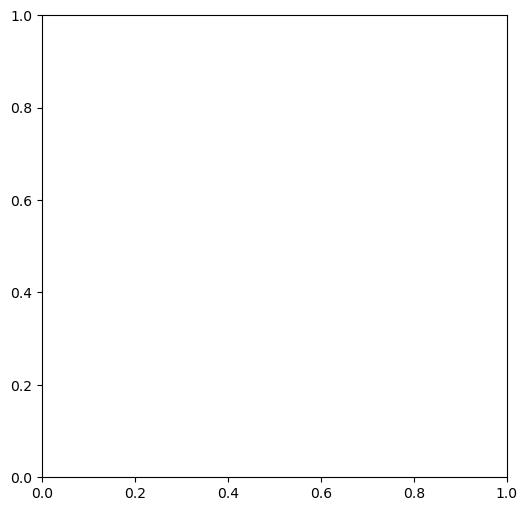

In [136]:
plot_compare(metrics,gpu_res,num_round)


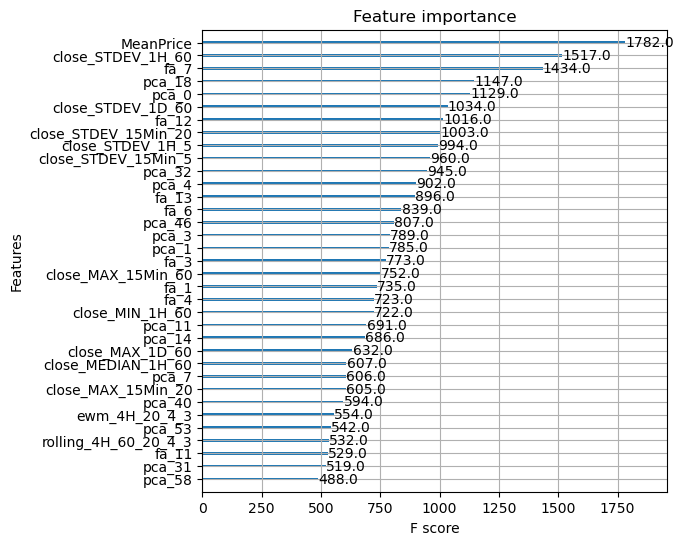

In [86]:
p = xgb.plot_importance(booster) 


In [137]:
f_score=booster.get_fscore()
selected=[key for key, value in f_score.items() if value > 5]
print(selected)
print(f_score)

['MeanPrice']
{'MeanPrice': 51.0}


In [24]:
# load the model from file
booster = joblib.load(os.path.join(temp_save_dir, 'xgb-4-1.joblib'))

In [138]:
dtest = xgb.DMatrix(testX, testY, enable_categorical=False)
pred = booster.predict(dtest)
print(pred.shape)
pred_vect = np.argmax(pred, axis=1).reshape(-1,1)



(1057053,)


AxisError: axis 1 is out of bounds for array of dimension 1

In [111]:
from sklearn.metrics import accuracy_score, f1_score
pred_vect=pred_labels

print('-- Model Report --')
print('XGBoost Accuracy: '+str(accuracy_score(pred_vect, testY)))
print('XGBoost F1-Score (Micro): '+str(f1_score(pred_vect,testY,average='micro')))

-- Model Report --
XGBoost Accuracy: 0.004983666854925912
XGBoost F1-Score (Micro): 0.004983666854925912


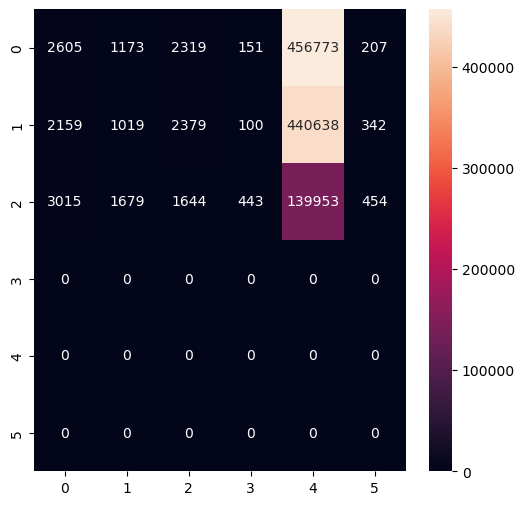

In [112]:
from sklearn.metrics import confusion_matrix
import pylab as pl

import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(testY, pred_vect)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation



